<p align="center">
  <strong style="font-size:2em; color:red;">VQE TUTORIAL</strong>
</p>

## **Random Example** 

Given the Hamiltonian $$ 2II - 2XX + 3YY -3ZZ $$
we find its minimal eigenvalue using `StatevectorEsitmator` method and `COBYLA` classical optimisation

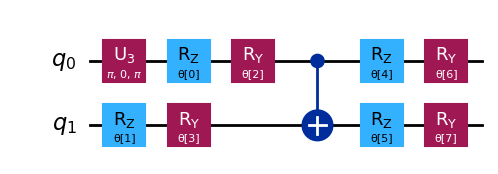

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np
 
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])
 
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)
 
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
 
ansatz = reference_circuit.compose(variational_form)
 
ansatz.decompose().draw("mpl")

In [2]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
 
    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]
 
    cost = estimator_result.data.evs[0]
    return cost

In [3]:
from qiskit.primitives import StatevectorEstimator
 
estimator = StatevectorEstimator()

In [4]:
# SciPy minimizer routine
from scipy.optimize import minimize
 
x0 = np.ones(8)
 
result = minimize(
    cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA"
)
 
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999957125782
       x: [ 1.739e+00  9.302e-01  1.571e+00  1.167e-05  1.910e+00
            1.231e+00  6.226e-01  6.227e-01]
    nfev: 131
   maxcv: 0.0

## **Problem Definition**

Imagine that we want to use a variational algorithm to find the eigenvalue of the following observable:

$$\hat{O}_1 = 2II - 2XX + 3YY - 3ZZ,
$$


This observable has the following eigenvalues:


\begin{cases}
\lambda_0 = -6 \\
\lambda_1 = 4 \\
\lambda_2 = 4 \\
\lambda_3 = 6
\end{cases}


And corresponding eigenstates:


\begin{cases}
\lvert \phi_0 \rangle = \frac{1}{\sqrt{2}} (\lvert 00 \rangle + \lvert 11 \rangle) \\
\lvert \phi_1 \rangle = \frac{1}{\sqrt{2}} (\lvert 00 \rangle - \lvert 11 \rangle) \\
\lvert \phi_2 \rangle = \frac{1}{\sqrt{2}} (\lvert 01 \rangle - \lvert 10 \rangle) \\
\lvert \phi_3 \rangle = \frac{1}{\sqrt{2}} (\lvert 01 \rangle + \lvert 10 \rangle)
\end{cases}



[1. 1. 1. 1. 1. 1. 1. 1.]


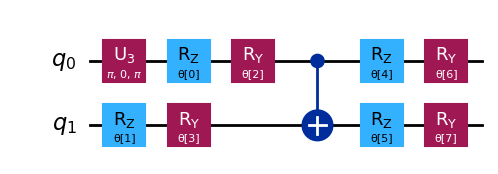

In [60]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
import numpy as np
 
observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
 
    return cost

 
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)
 
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)
x0 = np.ones(raw_ansatz.num_parameters)

print(x0)
raw_ansatz.decompose().draw("mpl")



In [17]:

# SciPy minimizer routine
from scipy.optimize import minimize
import time
 
start_time = time.time()
 
result = minimize(
    cost_func_vqe,
    x0,
    args=(raw_ansatz, observable_1, estimator),
    method="COBYLA",
    options={"maxiter": 1000, "disp": True},
)
 
end_time = time.time()
execution_time = end_time - start_time

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999957125782
       x: [ 1.739e+00  9.302e-01  1.571e+00  1.167e-05  1.910e+00
            1.231e+00  6.226e-01  6.227e-01]
    nfev: 131
   maxcv: 0.0

In [16]:
from numpy.linalg import eigvalsh
 
solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))
 
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")
 
print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 131
Time (s): 0.2884485721588135
Percent error: 7.15e-09


In [19]:
optimal_params = result.x
optimal_params

array([1.73921703e+00, 9.30185211e-01, 1.57079524e+00, 1.16674172e-05,
       1.91008264e+00, 1.23141063e+00, 6.22590860e-01, 6.22671247e-01])

In [42]:
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np

# 1. Simulate the final variational state
bound_circuit = raw_ansatz.assign_parameters(optimal_params, inplace=False)
final_state = Statevector.from_instruction(bound_circuit)

# 2. Build the known target eigenstate (Bell state)
phi0 = Statevector.from_label("00") + Statevector.from_label("11")
phi0 = phi0 / np.linalg.norm(phi0.data)

# 3. Compute fidelity
fidelity = state_fidelity(final_state, phi0)
print(f"Fidelity w.r.t. target eigenstate: {fidelity:.4f}")


Fidelity w.r.t. target eigenstate: 1.0000


# **Experimenting to improve speed and accuracy**

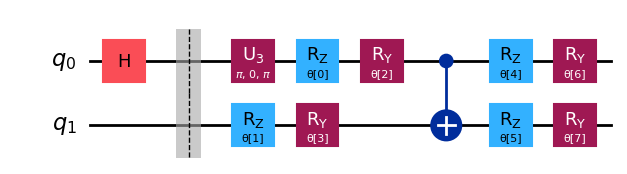

In [ ]:
reference = QuantumCircuit(2)
reference.h(0)
# Include barrier to separate reference from variational form
reference.barrier()
 
ref_ansatz = raw_ansatz.decompose().compose(reference, front=True)
 
ref_ansatz.draw("mpl")

In [49]:
import time
 
start_time = time.time()
 
ref_result = minimize(
    cost_func_vqe, x0, args=(ref_ansatz, observable_1, estimator), method="COBYLA"
)
 
end_time = time.time()
execution_time = end_time - start_time

ref_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999677544318
       x: [ 1.571e+00  2.746e+00  5.113e-01 -4.490e-05  1.798e+00
            2.914e+00  1.024e+00  1.024e+00]
    nfev: 205
   maxcv: 0.0

In [47]:
experimental_min_eigenvalue_ref = cost_func_vqe(
    result.x, raw_ansatz, observable_1, estimator
)
print(experimental_min_eigenvalue_ref)

-5.999999957125782


In [55]:
print("ADDED REFERENCE STATE:")
print(f"""Number of iterations: {ref_result.nfev}""")
print(f"""Time (s): {execution_time}""")
print(
    f"Percent error: {abs((experimental_min_eigenvalue_ref - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

ADDED REFERENCE STATE:
Number of iterations: 205
Time (s): 0.33827948570251465
Percent error: 7.15e-09


# **Change the initial point**

In [59]:
import time
 
start_time = time.time()
 
x0 = [0, 0, 0, 6, 0, 0, 0, 0]
 
x0_1_result = minimize(
    cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA"
)
 
end_time = time.time()
execution_time = end_time - start_time
print("INITIAL POINT 1:")
print(f"""Number of iterations: {x0_1_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 1:
Number of iterations: 124
Time (s): 0.2987709045410156


In [52]:
import time
 
start_time = time.time()
 
x0 = 6 * np.ones(raw_ansatz.num_parameters)
 
x0_2_result = minimize(
    cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA"
)
 
end_time = time.time()
execution_time = end_time - start_time

print("INITIAL POINT 2:")
print(f"""Number of iterations: {x0_2_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 2:
Number of iterations: 120
Time (s): 0.29395365715026855


# **Experimenting with different optimizers**

In [54]:
import time
 
start_time = time.time()
 
result = minimize(
    cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="BFGS"
)
 
end_time = time.time()
execution_time = end_time - start_time

print("CHANGED TO BFGS OPTIMIZER:")
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

CHANGED TO BFGS OPTIMIZER:
Number of iterations: 117
Time (s): 0.33827948570251465
